In [2]:
import sys

!{sys.executable} -m pip install --quiet --disable-pip-version-check httpx
!{sys.executable} -m pip install --quiet --disable-pip-version-check --upgrade --pre --index-url https://www.myget.org/F/apollo3zehn-dev/python/ nexusapi

In [9]:
from httpx import AsyncClient
from nexusapi import NexusAsyncClient

refresh_token = "<refresh-token>"

base_url = "https://localhost:8443"
client = NexusAsyncClient(AsyncClient(base_url=base_url, verify=False)) # NexusAsyncClient.create(base_url)
await client.sign_in(refresh_token)

In [10]:
from typing import List
from datetime import datetime, timedelta, timezone

begin = datetime(2020, 2, 1, 0, 0, tzinfo=timezone.utc)
end   = datetime(2020, 2, 2, 0, 0, tzinfo=timezone.utc)

# Get T1 data

# /* Example: Transmit additional configuration which is understood only by the sample data source. */
with client.attach_configuration2(\
    ("user", "test"), \
    ("password", "1234")):
    async with await client.data.get_stream("/SAMPLE/FORWARDED", "T1", "1_s", begin, end) as response:
        t1_data = await response.get_data()

# Get V1 data
async with await client.data.get_stream("/SAMPLE/ACCESSIBLE", "V1", "1_s", begin, end) as response:
    v1_data = await response.get_data()

# timestamps
timestamps = [begin + timedelta(seconds=x) for x in range(0, len(t1_data))]

In [11]:
# metadata
metadata1 = await client.catalogs.get("/SAMPLE/FORWARDED")

if not metadata1.resources:
    raise Exception("resources is null")

t1_metadata = next(resource for resource in metadata1.resources if resource.id == "T1")

if not t1_metadata.properties:
    raise Exception("properties is null")

t1_description = t1_metadata.properties["description"]
t1_unit = t1_metadata.properties["unit"]

metadata2 = await client.catalogs.get("/SAMPLE/ACCESSIBLE")

if not metadata2.resources:
    raise Exception("resources is null")

v1_metadata = next(resource for resource in metadata2.resources if resource.id == "V1")

if not v1_metadata.properties:
    raise Exception("properties is null")

v1_description = v1_metadata.properties["description"]
v1_unit = v1_metadata.properties["unit"]

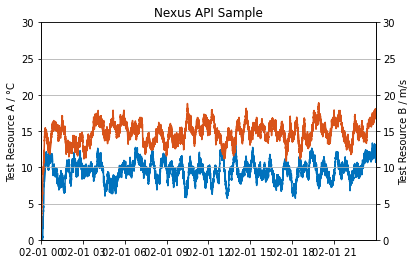

In [12]:
import matplotlib.pyplot as plt

# plot
r1 = plt.gca()
r1.plot(timestamps, t1_data, color=(0, 0.4470, 0.7410))
r1.set_ylabel(f"{t1_description} / {t1_unit}")
r1.set_ylim(0, 30)

r2 = r1.twinx()
r2.plot(timestamps, v1_data, color=(0.8500, 0.3250, 0.0980))
r2.set_ylabel(f"{v1_description} / {v1_unit}")
r2.set_ylim(0, 30)

plt.title("Nexus API Sample")
plt.xlabel("Time")
plt.xlim(timestamps[0], timestamps[-1])
plt.grid()
plt.show()